In [1]:
# Copyright 2021 Annika Vogt
# Copyright 2021 ST John
# Copyright 2016 James Hensman, Nicolas Durrande
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.vq import kmeans
from VFF.vgp import VGP_kron
import gpflow
from matplotlib import pyplot as plt
import tensorflow as tf

from gpflow.utilities import print_summary
gpflow.config.set_default_summary_fmt("notebook")

from time import time

In [2]:
X = np.loadtxt("banana_X_train", delimiter=",")
Y = np.loadtxt("banana_Y_train")[:, None]


lik = gpflow.likelihoods.Bernoulli
k = gpflow.kernels.Matern32

a = X.min(0) - 2.5
b = X.max(0) + 2.5

In [3]:
def plot(m, ax):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    xtest, ytest = np.mgrid[-2.5:2.5:100j, -2.5:2.5:100j]
    Xtest = np.vstack((xtest.flatten(), ytest.flatten())).T
    for i, mark in [[0, "x"], [1, "o"]]:
        ind = Y[:, 0] == i
        ax.plot(X[ind, 0], X[ind, 1], mark)
    mu, var = m.predict_y(Xtest)
    ax.contour(xtest, ytest, mu.numpy().reshape(100, 100), levels=[0.5], colors="C0", linewidths=4)

    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)    

In [4]:
models = []
labels = []

In [5]:
# Variational Fourier Features
for M in [2,4,8,16]:
    
    m = VGP_kron(
        (X, Y), np.arange(M), a=a, b=b, kernels=[k(), k()], likelihood=lik(), use_two_krons=True
    )
    
    print_summary(m)
    models.append(m)
    labels.append(f"VFF {M}")
    
    # sparse
    Ts = [-1,0,0.1]
    ds = np.array([M+1]*np.size(Ts))
    
    for T,d in zip(Ts,ds):
        m = VGP_kron(
            (X, Y), np.arange(M), a=a, b=b, kernels=[k(), k()], likelihood=lik(), use_two_krons=True, d=d, T=T, sparse=True
        )   
        models.append(m)
        labels.append(f"VFF {M} sparse. d = {d}, T = {T}")


name,class,transform,prior,trainable,shape,dtype,value
VGP_kron.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.q_mu,Parameter,Identity,,True,"(9, 1)",float64,[[0....
VGP_kron.q_sqrt_kron[0],Parameter,Identity,,True,"(3, 3)",float64,"[[1., 0., 0...."
VGP_kron.q_sqrt_kron[1],Parameter,Identity,,True,"(3, 3)",float64,"[[1., 0., 0...."
VGP_kron.q_sqrt_kron_2[0],Parameter,Identity,,True,"(3, 3)",float64,"[[1.01, 0.01, 0.01..."
VGP_kron.q_sqrt_kron_2[1],Parameter,Identity,,True,"(3, 3)",float64,"[[1.01, 0.01, 0.01..."


name,class,transform,prior,trainable,shape,dtype,value
VGP_kron.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.q_mu,Parameter,Identity,,True,"(49, 1)",float64,[[0....
VGP_kron.q_sqrt_kron[0],Parameter,Identity,,True,"(7, 7)",float64,"[[1., 0., 0...."
VGP_kron.q_sqrt_kron[1],Parameter,Identity,,True,"(7, 7)",float64,"[[1., 0., 0...."
VGP_kron.q_sqrt_kron_2[0],Parameter,Identity,,True,"(7, 7)",float64,"[[1.01, 0.01, 0.01..."
VGP_kron.q_sqrt_kron_2[1],Parameter,Identity,,True,"(7, 7)",float64,"[[1.01, 0.01, 0.01..."


name,class,transform,prior,trainable,shape,dtype,value
VGP_kron.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.q_mu,Parameter,Identity,,True,"(225, 1)",float64,[[0....
VGP_kron.q_sqrt_kron[0],Parameter,Identity,,True,"(15, 15)",float64,"[[1., 0., 0...."
VGP_kron.q_sqrt_kron[1],Parameter,Identity,,True,"(15, 15)",float64,"[[1., 0., 0...."
VGP_kron.q_sqrt_kron_2[0],Parameter,Identity,,True,"(15, 15)",float64,"[[1.01, 0.01, 0.01..."
VGP_kron.q_sqrt_kron_2[1],Parameter,Identity,,True,"(15, 15)",float64,"[[1.01, 0.01, 0.01..."


name,class,transform,prior,trainable,shape,dtype,value
VGP_kron.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP_kron.q_mu,Parameter,Identity,,True,"(961, 1)",float64,[[0....
VGP_kron.q_sqrt_kron[0],Parameter,Identity,,True,"(31, 31)",float64,"[[1., 0., 0...."
VGP_kron.q_sqrt_kron[1],Parameter,Identity,,True,"(31, 31)",float64,"[[1., 0., 0...."
VGP_kron.q_sqrt_kron_2[0],Parameter,Identity,,True,"(31, 31)",float64,"[[1.01, 0.01, 0.01..."
VGP_kron.q_sqrt_kron_2[1],Parameter,Identity,,True,"(31, 31)",float64,"[[1.01, 0.01, 0.01..."


In [6]:
for label, m in zip(labels, models):
    print(f"Optimizing {label}")
    start = time()
    try:
        o = gpflow.optimizers.Scipy()
        if isinstance(m, gpflow.models.ExternalDataTrainingLossMixin):
            loss = m.training_loss_closure((X, Y))
        else:
            loss = m.training_loss
        o.minimize(loss, m.trainable_variables)
    except:
        print("model optimization failed")
        
    print (round(time()-start), "s")
    print()

Optimizing VFF 2
6 s

Optimizing VFF 2 sparse. d = 3, T = -1
3 s

Optimizing VFF 2 sparse. d = 3, T = 0
3 s

Optimizing VFF 2 sparse. d = 3, T = 0.1
4 s

Optimizing VFF 4
4 s

Optimizing VFF 4 sparse. d = 5, T = -1
4 s

Optimizing VFF 4 sparse. d = 5, T = 0
4 s

Optimizing VFF 4 sparse. d = 5, T = 0.1
4 s

Optimizing VFF 8
8 s

Optimizing VFF 8 sparse. d = 9, T = -1
6 s

Optimizing VFF 8 sparse. d = 9, T = 0
6 s

Optimizing VFF 8 sparse. d = 9, T = 0.1
7 s

Optimizing VFF 16
21 s

Optimizing VFF 16 sparse. d = 17, T = -1
13 s

Optimizing VFF 16 sparse. d = 17, T = 0
14 s

Optimizing VFF 16 sparse. d = 17, T = 0.1
18 s



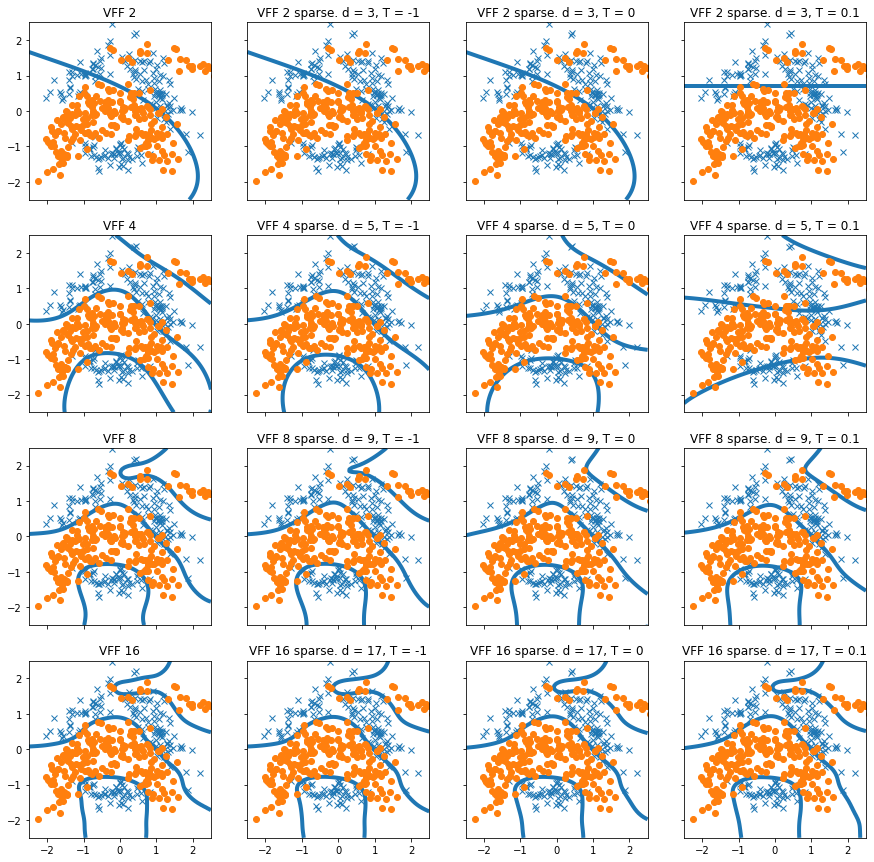

In [7]:
f, axes = plt.subplots(int(np.size(labels)/(np.size(Ts)+1)), np.size(Ts)+1, sharex=True, sharey=True, figsize=(15, 15))
axes = axes.flatten()

for ax, label, m in zip(axes, labels, models):
    plot(m, ax)
    if isinstance(m, gpflow.models.SVGP):
        ax.plot(m.inducing_variable.Z[:, 0], m.inducing_variable.Z[:, 1], "ko", ms=4)
    ax.set_title(label)
        
# m2t.save('banana_compare.tikz')
plt.savefig("banana_compare.png", dpi=150)

In [8]:
fp = open("Banana Preciseness.txt", "w") 

for i, label, m in zip(range(np.size(labels)), labels, models):
    mu, var = m.predict_y(X)
    fp.write(label)
    fp.write(' %f' %(sum(np.equal(np.round(mu), Y)[:,0] * np.equal(np.round(mu), Y)[:,0])/Y.shape[0]))
    fp.write('\n')
    
fp.close() 